In [14]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from IPython.display import display

from disruption_survival_analysis.sweep_config import create_experiment_groups, get_experiments


from disruption_survival_analysis.plot_experiments import plot_true_alarm_rates_vs_thresholds, plot_false_alarm_rates_vs_thresholds, plot_warning_times_vs_thresholds
from disruption_survival_analysis.plot_experiments import plot_true_alarm_rates_vs_false_alarm_rates, plot_missed_alarm_rates_vs_false_alarm_rates, plot_avg_warning_times_vs_false_alarm_rates


#device = 'synthetic'
#dataset_path = 'test'
devices = ['cmod']
#dataset_paths = ['preliminary_dataset_no_ufo']
#dataset = 'sql_all_no_ufo'
dataset='sql_match'
dataset_paths = [f"{dataset}/stack_10"]

# models, alarms, metrics, and minimum warning times to use
models = ['cph', 'dsm', 'rf', 'km']
#models = ['rf']
alarms = ['sthr']
metrics = ['auroc']
min_warning_times = [0.01, 0.05, 0.1]

# Load models and create experiments
experiment_groups = create_experiment_groups(devices, dataset_paths, models, alarms, metrics, min_warning_times)

# C

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-20 09:10:39,512] Study name was omitted but trying to load 'cph_sthr_auroc_10ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/sql_match/stack_10/studies/cph_sthr_auroc_10ms_study.db
Best validation metric is 0.6638765705058396 from trial 639
---


c:\Users\zkeith\proj\disruption-survival-analysis\.venv\lib\site-packages\lifelines\utils\__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]


Saved model to models/cmod/sql_match/stack_10/cph_sthr_auroc_10ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-20 09:14:19,157] Study name was omitted but trying to load 'cph_sthr_auroc_50ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/sql_match/stack_10/studies/cph_sthr_auroc_50ms_study.db
Best validation metric is 0.5297477916982355 from trial 3866
---


c:\Users\zkeith\proj\disruption-survival-analysis\.venv\lib\site-packages\lifelines\utils\__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]


Saved model to models/cmod/sql_match/stack_10/cph_sthr_auroc_50ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-20 09:16:38,898] Study name was omitted but trying to load 'cph_sthr_auroc_100ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/sql_match/stack_10/studies/cph_sthr_auroc_100ms_study.db
Best validation metric is 0.47206264316517016 from trial 4828
---


c:\Users\zkeith\proj\disruption-survival-analysis\.venv\lib\site-packages\lifelines\utils\__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]


Saved model to models/cmod/sql_match/stack_10/cph_sthr_auroc_100ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-20 09:18:58,762] Study name was omitted but trying to load 'dsm_sthr_auroc_10ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/sql_match/stack_10/studies/dsm_sthr_auroc_10ms_study.db
Best validation metric is 0.8154292651578245 from trial 1226
---


100%|██████████| 50/50 [18:19<00:00, 21.99s/it]


Saved model to models/cmod/sql_match/stack_10/dsm_sthr_auroc_10ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-20 09:39:20,378] Study name was omitted but trying to load 'dsm_sthr_auroc_50ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/sql_match/stack_10/studies/dsm_sthr_auroc_50ms_study.db
Best validation metric is 0.754444439662472 from trial 4684
---


 84%|████████▍ | 42/50 [12:23<02:21, 17.70s/it]
c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-20 09:52:59,087] Study name was omitted but trying to load 'dsm_sthr_auroc_100ms' because that was the only study found in the storage.


Saved model to models/cmod/sql_match/stack_10/dsm_sthr_auroc_50ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...
Loaded hyperparameters for cmod/sql_match/stack_10/studies/dsm_sthr_auroc_100ms_study.db
Best validation metric is 0.7050236385954738 from trial 392
---


100%|██████████| 50/50 [32:38<00:00, 39.16s/it]


Saved model to models/cmod/sql_match/stack_10/dsm_sthr_auroc_100ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/sql_match/stack_10/configs/rf_sthr_auroc_10ms.yaml
---
Loaded model from models/cmod/sql_match/stack_10/rf_sthr_auroc_10ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/sql_match/stack_10/configs/rf_sthr_auroc_50ms.yaml
---
Loaded model from models/cmod/sql_match/stack_10/rf_sthr_auroc_50ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/sql_match/stack_10/configs/rf_sthr_auroc_100ms.yaml
---
Loaded model from models/cmod/sql_match/stack_10/rf_sthr_auroc_100ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-20 10:28:37,920] Study name was omitted but trying to load 'km_sthr_auroc_10ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/sql_match/stack_10/studies/km_sthr_auroc_10ms_study.db
Best validation metric is 0.8064232695659985 from trial 1189
---
Loaded model from models/cmod/sql_match/stack_10/km_sthr_auroc_10ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-20 10:28:49,423] Study name was omitted but trying to load 'km_sthr_auroc_50ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/sql_match/stack_10/studies/km_sthr_auroc_50ms_study.db
Best validation metric is 0.7736550913157758 from trial 2742
---
Loaded model from models/cmod/sql_match/stack_10/km_sthr_auroc_50ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-20 10:29:00,750] Study name was omitted but trying to load 'km_sthr_auroc_100ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/sql_match/stack_10/studies/km_sthr_auroc_100ms_study.db
Best validation metric is 0.7462418630159702 from trial 1590
---
Loaded model from models/cmod/sql_match/stack_10/km_sthr_auroc_100ms.pkl


c:\Users\zkeith\proj\disruption-survival-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


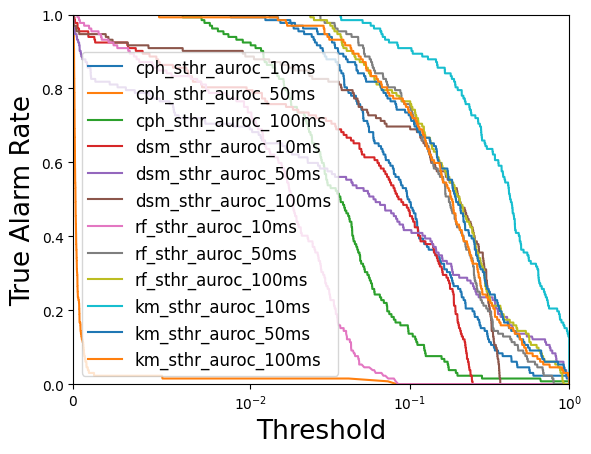

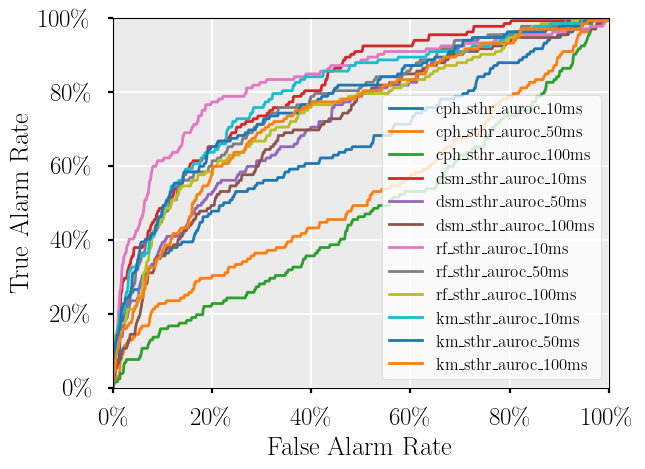

In [15]:
# Pre-compute and cache all values for all experiments
experiment_list = get_experiments(experiment_groups, ['auroc'])
plot_true_alarm_rates_vs_thresholds(experiment_list)
plot_true_alarm_rates_vs_false_alarm_rates(experiment_list)

## Threshold Plots



In [16]:
# Save experiment_groups to disk
import dill
with open(f"experiment_groups_{dataset}.pkl", 'wb') as f:
    dill.dump(experiment_groups, f)

In [3]:
# Load experiment_groups from disk
import dill
with open(f"experiment_groups_{dataset}.pkl", 'rb') as f:
    experiment_groups = dill.load(f)

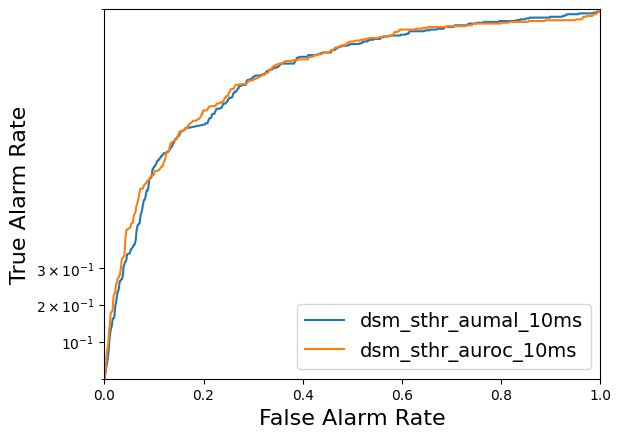

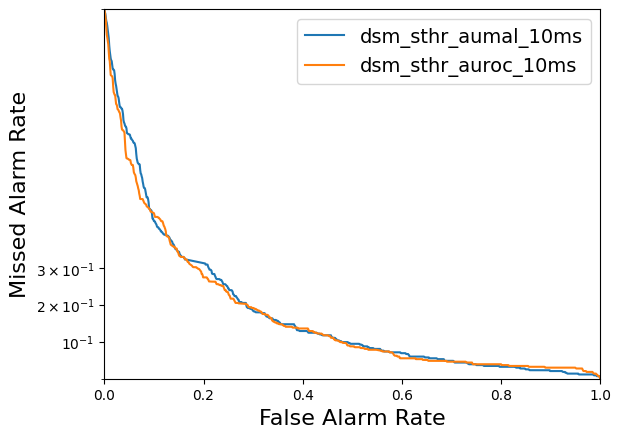

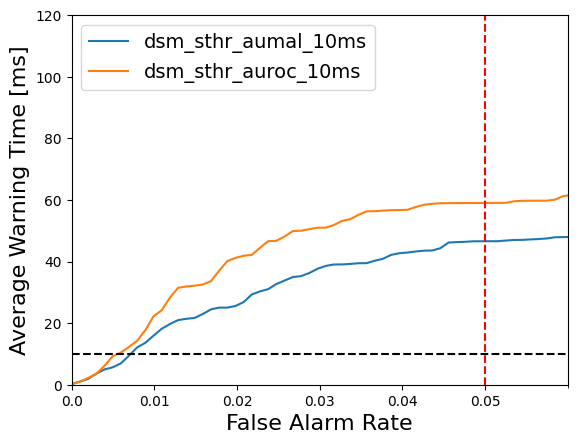

AUROC:	 0.8237577217568832
AUMAL:	 -1.021803900966191
AUROC:	 0.8288058498916338
AUMAL:	 -0.9983355870708333


In [7]:
required_warning_time = 0.01
experiment_list = get_experiments(experiment_groups, 
                                  [dataset, 'dsm', 'aumal', required_warning_time],
                                  [dataset, 'dsm', 'auroc', required_warning_time])

plot_true_alarm_rates_vs_false_alarm_rates(experiment_list)
plot_missed_alarm_rates_vs_false_alarm_rates(experiment_list)
plot_avg_warning_times_vs_false_alarm_rates(experiment_list, required_warning_time)
#plot_true_alarm_rates_vs_thresholds(experiment_list)
#plot_false_alarm_rates_vs_thresholds(experiment_list)
#plot_warning_times_vs_thresholds(experiment_list)

for experiment in experiment_list:
    aumal = experiment.evaluate_metric('aumal')
    auroc = experiment.evaluate_metric('auroc')
    print(f"AUROC:\t {auroc}")
    print(f"AUMAL:\t {aumal}")

## ROC Curve

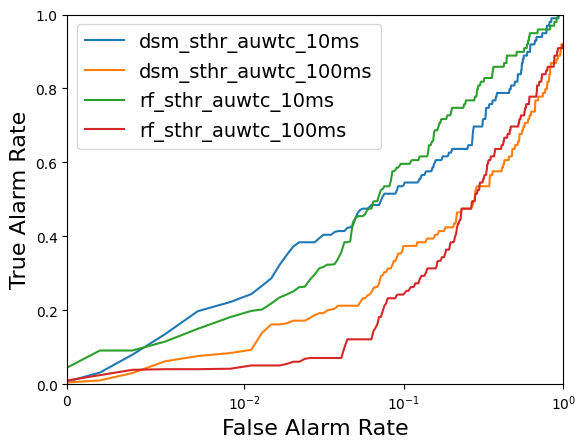

## Area Under Warning Time Curve



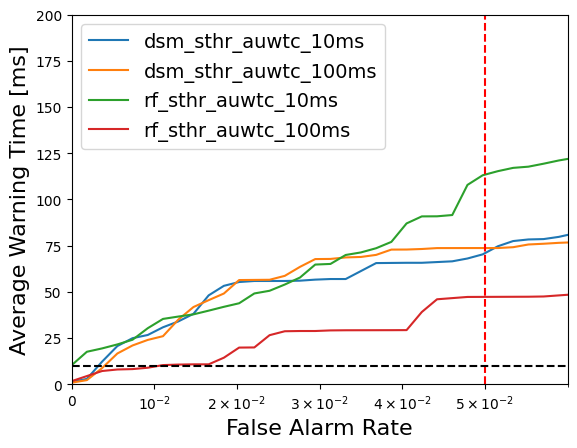